# Redes neurais convolucionais - Convolutional Neural Networks (CNN)

Como visto em aula, redes convolucionais são modelos que apreendem filtros para transformar imagens em representações vetoriais.

<table>
<tr>
<td>
<img align="middle"  width='300' heith='100' src='images/arbitrary_padding_no_strides_transposed.gif'>
</td>
</tr>
</table>

(imagem retirada de [Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic)) 




##  Classificação de imagens usando uma CNN

Vamos continuar usando o problema de carro autônomo como exemplo de classificação de imagens.

In [1]:
# notebook feito para a versão 0.4.0 do Pytorch 
import os
import subprocess
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from plots import plot9images, plot_confusion_matrix
from util import randomize_in_place
from DataHolder import DataHolderGentle
% matplotlib inline
print("PyTorch version = {} ".format(torch.__version__))

PyTorch version = 0.4.0 


Baixando os dados

In [2]:
# Essa célula pode demorar de acordo com sua conexão de internet.
# Olhe o terminal para mais informações sobre o download
if not os.path.exists("self_driving_pi_car_data"):
    pro = subprocess.Popen(["bash", "download.sh"])
    pro.wait()

Novamente vamos usar apenas um pedaço dos dados.

In [3]:
raw_X = np.load("self_driving_pi_car_data/train_data.npy")
raw_y = np.load("self_driving_pi_car_data/train_labels.npy")
randomize_in_place(raw_X, raw_y)
valid_X = raw_X[0:1000]
valid_y = raw_y[0:1000]
test_X = raw_X[1000:2000]
test_y = raw_y[1000:2000]
train_X = raw_X[2000:]
train_y = raw_y[2000:]
labels_legend = ["forward", "left", "right"]

del raw_X
del raw_y

Uma CNN tem como entrada uma imagem como uma matrix, não como um vetor. 

Vamos alterar o formato dos nossos dados para ficar do modo correto, aqui vamos usar o formato **(canais, altura, largura)**.

In [4]:
valid_X = valid_X.reshape((-1, 3, 45, 80))
test_X = test_X.reshape((-1, 3, 45, 80))
train_X = train_X.reshape((-1, 3, 45, 80))

In [5]:
command2int = {"forward": 0, "left": 1, "right": 2}
int2command = {i[1]: i[0] for i in command2int.items()}

print("Informações sobre os dados\n")
print("- Formato dos dados de treinamento = {}\n".format(train_X.shape))
print("- Formato dos dados de validação = {}\n".format(valid_X.shape))
print("- Formato dos dados de teste = {}\n".format(test_X.shape))
print("- Número de classes = {}\n".format(3))
print("- Legenda das classes:  (0 = forward, 1 = left, 2 = right)\n")

Informações sobre os dados

- Formato dos dados de treinamento = (54172, 3, 45, 80)

- Formato dos dados de validação = (1000, 3, 45, 80)

- Formato dos dados de teste = (1000, 3, 45, 80)

- Número de classes = 3

- Legenda das classes:  (0 = forward, 1 = left, 2 = right)



Olhando alguns exemplos: 

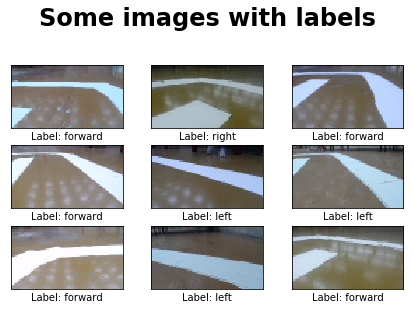

In [6]:
img9 = train_X[0:9]
labels9 = train_y[0:9]
labels9 = [int2command[i] for i in labels9]
img9 = img9.reshape((9, 45, 80, 3)) 
img9 = img9[...,::-1]
plot9images(img9, labels9, (45, 80, 3))

Também podemos olhar como estão as distribuição das classes nos diferentes conjuntos de dados

##  Criando a classe de configuração para a CNN

Como nos casos anteriores, vamos usar uma classe para guardar todos os hiper parâmetros relacionado a CNN.

In [7]:
class CNNConfig(object):
    """
    Holds model hyperparams.
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param architecture: network dense architecture
    :type architecture: list of int
    :param conv_architecture: convolutional architecture
    :type conv_architecture: list of int
    :param kernel_sizes: filter sizes
    :type kernel_sizes: list of int
    :param pool_kernel: pooling filter sizes
    :type pool_kernel: list of int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    """
    def __init__(self,
                 height=45,
                 width=80,
                 channels=3,
                 classes=3,
                 architecture=[100, 3],
                 conv_architecture=[12, 16],
                 kernel_sizes=None,
                 pool_kernel=None,
                 save_step=100,
                 batch_size=32,
                 epochs=1,
                 learning_rate=0.0054,
                 momentum=0.1):
        if kernel_sizes is None:
            self.kernel_sizes = [5] * len(conv_architecture)
        else:
            self.kernel_sizes = kernel_sizes
        if pool_kernel is None:
            self.pool_kernel = [2] * len(conv_architecture)
        else:
            pool_kernel = self.pool_kernel
        self.height = height
        self.width = width
        self.channels = channels
        self.classes = classes
        self.architecture = architecture
        self.conv_architecture = conv_architecture
        self.batch_size = batch_size
        self.epochs = epochs
        self.save_step = save_step
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "height = {}\n".format(self.height)
        status += "width = {}\n".format(self.width)
        status += "channels = {}\n".format(self.channels)
        status += "classes = {}\n".format(self.classes)
        status += "architecture = {}\n".format(self.architecture)
        status += "conv_architecture = {}\n".format(self.conv_architecture)
        status += "kernel_sizes = {}\n".format(self.kernel_sizes)
        status += "pool_kernel = {}\n".format(self.pool_kernel)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        status += "save_step = {}\n".format(self.save_step)
        
        
        return status


In [9]:
cnn_config = CNNConfig()
print("Os hiper parâmetros da rede convolucional são:\n")
print(cnn_config)

Os hiper parâmetros da rede convolucional são:

height = 45
width = 80
channels = 3
classes = 3
architecture = [100, 3]
conv_architecture = [12, 16]
kernel_sizes = [5, 5]
pool_kernel = [2, 2]
batch_size = 32
epochs = 1
learning_rate = 0.0054
momentum = 0.1
save_step = 100



Vamos transformar as imagens em tensores e vamos usar a classe `TensorDataset` para guardar os dados.

In [10]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(torch.Tensor(train_X),
                              torch.Tensor(train_y).type(torch.LongTensor))
valid_dataset = TensorDataset(torch.Tensor(valid_X),
                              torch.Tensor(valid_y).type(torch.LongTensor))
test_dataset = TensorDataset(torch.Tensor(test_X),
                              torch.Tensor(test_y).type(torch.LongTensor))

self_driving_data = DataHolderGentle(cnn_config, train_dataset, valid_dataset, test_dataset) 

###  **Exercício **

Complete a classe `CNN`.

Essa classe é uma implementação de uma CNN arbitrária. Assim, por exemplo, se forem passado os hiper parâmetros:

- `architecture = [100, 3]`
- `conv_architecture = [12, 16]`
- `kernel_sizes = [5, 3]`
- `pool_kernel = [3, 2]`

essa classe precisa definir uma CNN com duas camadas de **convolução** uma com 12 filtros de tamanho (5, 5) e outra com 16 filtros de tamanho (3, 3). Duas camadas de **pooling** (depois das camadas de convolução) com o filtros de tamanho (3, 3) e (2, 2) respectivamente. Uma **camada escondida** com 100 neurônios e a **camada de saída** com tamanho 3.

Lembre que vamos definir uma rede convolucional da seguinte forma:


<table>
<tr>
<td>
<img align="middle"  width='800' heith='100' src='images/cnn_arch.png'>
</td>
</tr>
</table>

(imagem retirada de [Introduction to Deep Learning: What Are Convolutional Neural Networks?](https://www.mathworks.com/videos/introduction-to-deep-learning-what-are-convolutional-neural-networks--1489512765771.html)) 

Ou seja, sempre vamos usar o seguinte padrão para a parte de convolução:


**camada de convolução - ReLU - camada de pooling**


Por isso que os parâmetros - `conv_architecture`, `kernel_sizes` e `pool_kernel` precisam ter sempre o mesmo tamanho.
 
Você deve definir a inicialização dessa classe e completar os métodos `forward` e `predict`. Note que:

 - o método `forward` deve retornar apenas os *logits*.
 
 - o método `predict` deve retornar $\mathbf{\hat{y}}$. Ainda estamos num problema de classificação com várias classes, então a saida da rede, $\mathbf{\hat{y}}$, é o resultado da função softmax aplicada aos *logits*.


In [76]:
class CNN(nn.Module):
    """
    Convolutional neural network model.
    
    You may find nn.Conv2d, nn.MaxPool2d and add_module useful here.
    
    :param config: hyper params configuration
    :type config: CNNConfig
    """
    def __init__(self,config):
        super(CNN, self).__init__()
        # YOUR CODE HERE:
        self.c = nn.ModuleList()
        self.r = nn.ModuleList()
        self.m = nn.ModuleList()
        
        self.l = nn.ModuleList()
        
        self.sm = nn.Softmax(dim = 1)
        w = config.width
        h = config.height
        d = config.channels
        self.momentum = config.momentum
        self.lr = config.learning_rate
        
        
        for j in range(len(config.conv_architecture)):
            #print(d,h,w)
            nIn = config.channels if j == 0 else config.conv_architecture[j - 1]
            nOut = config.conv_architecture[j]
            self.c.append(nn.Conv2d(nIn, nOut, kernel_size=config.kernel_sizes[j]))
            w = w - config.kernel_sizes[j] + 1
            h = h - config.kernel_sizes[j] + 1
            d = nOut
            #print(d,h,w)
            self.r.append(nn.ReLU())
            self.m.append(nn.MaxPool2d(kernel_size=config.pool_kernel[j],stride=1))
            w = w - config.pool_kernel[j] + 1
            h = h - config.pool_kernel[j] + 1
            d = d
            
        #print(d,h,w)
        #print(d*h*w)
        for j in range(len(config.architecture)):
            nIn = w*h*d if j == 0 else config.architecture[j - 1]
            nOut = config.architecture[j]
            self.l.append(nn.Linear(nIn,nOut))
        # END YOUR CODE
    
    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: logits
        :rtype: torch.FloatTensor(shape=[batch_size, number_of_classes])
        """
        # YOUR CODE HERE:
        logits = x
        #print(logits.size())
        for c,r,m in zip(self.c, self.r,self.m):
            logits = c(logits)
            #print(logits.size())
            logits = r(logits)
            logits = m(logits)
            #print(logits.size())
            
        logits = logits.view(logits.size()[0], -1)
        #print(logits.size())
        for l in self.l:
            logits = l(logits)
        # END YOUR CODE        
        return logits
    
    
    def predict(self, x):
        """
        Computes model's prediction

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(batch_size, number_of_features))
        :return: model's predictions
        :rtype: torch.LongTensor(shape=[batch_size])
        """
        # YOUR CODE HERE:
        logits = self.forward(x)
        y_hat = self.sm(logits)
        _, predictions = torch.max(y_hat.t(), 0)
        # END YOUR CODE        
        return predictions

###  **Loop de treinamento**

Use a mesma função `train_model_img_classification` que voce definiu no notebook passado (pytorch_basico2.ipynb) para treinar o modelo.

In [83]:
def train_model_img_classification(model,
                                   config,
                                   dataholder,
                                   model_path,
                                   verbose=True):
    """
    Train a model for image classification

    :param model: image classification model
    :type model: LogisticRegression or DFN
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    train_loader = dataholder.train_loader
    valid_loader = dataholder.valid_loader

    best_valid_loss = float("inf")
    # YOUR CODE HERE:
    # i) define the loss criteria and the optimizer. 
    # You may find nn.CrossEntropyLoss and torch.optim.SGD useful here.
    criterion = nn.CrossEntropyLoss().cuda()

    optimizer = torch.optim.SGD(model.parameters(), config.learning_rate,
                                momentum=config.momentum)
    # END YOUR CODE
    
    train_loss = []
    valid_loss = []
    for epoch in range(config.epochs):
        for step, (images, labels) in enumerate(train_loader):
            # YOUR CODE HERE:
            # ii) You should zero the model gradients
            # and define the loss function for the train data.
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            # END YOUR CODE
            if step % config.save_step == 0:
                # YOUR CODE HERE:
                # iii) You should define the loss function for the valid data.
                v_loss = loss
                # END YOUR CODE
                valid_loss.append(float(v_loss))
                train_loss.append(float(loss))
                if float(v_loss) < best_valid_loss:
                    msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(loss),float(v_loss))
                    torch.save(model.state_dict(), model_path)
                    best_valid_loss = float(v_loss)
                    if verbose:
                        print(msg, end="")
            # YOUR CODE HERE:
            # iv) You should do the back propagation
            # and do the optimization step.
            loss.backward()
            optimizer.step()
            # END YOUR CODE
    if verbose:
        x = np.arange(1, len(train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, train_loss, label='train loss')
        ax.plot(x, valid_loss, label='valid loss')
        ax.legend()
        plt.xlabel('step')
        plt.ylabel('loss')
        plt.title('Train and valid loss')
        plt.grid(True)
        plt.show()

### Testes do exercício

Teste da saída do método `forward`

In [84]:
cnn_model = CNN(cnn_config)
images, labels = next(iter(self_driving_data.train_loader))
images = images / 255
out = cnn_model(images)
assert out.type() == 'torch.FloatTensor', "problemas com o tipo da saida do método forward"
assert out.shape == torch.Size([cnn_config.batch_size, cnn_config.classes]), "problemas com o shape da saida do método forward"

Teste da saída do método `predict`

In [85]:
prediction = cnn_model.predict(images)
assert prediction.type() == 'torch.LongTensor', "problemas com o tipo da saida do método prediction"
assert prediction.shape == torch.Size([cnn_config.batch_size]), "problemas com o shape da saida do método prediction"

Teste do treinamento do modelo


train_loss = 16.895 | valid_loss = 16.895

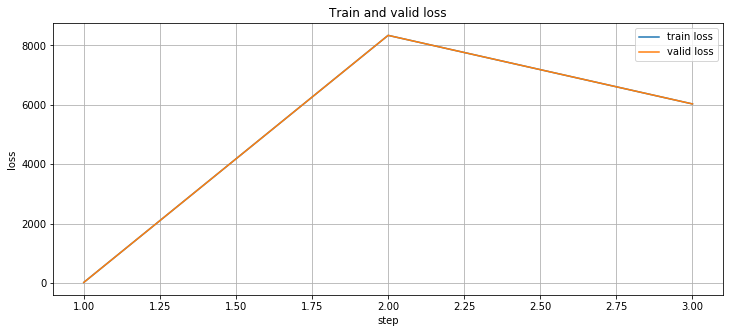

antes do treino, acc = 0.18
depois do treino, acc = 0.53


In [86]:
my_cnn_config = CNNConfig(epochs=1)
my_cnn_model = CNN(my_cnn_config)

test_img, test_labels = next(iter(self_driving_data.test_loader))
test_img = test_img / 255
pred = my_cnn_model.predict(test_img)
pred = pred.numpy()
accuracy_before = np.sum(pred == test_labels.numpy())/ test_labels.shape[0]

train_model_img_classification(my_cnn_model,
                               my_cnn_config,
                               self_driving_data,
                               'cnn.pkl',
                               verbose=True)

pred = my_cnn_model.predict(test_img)
pred = pred.numpy()
accuracy_after = np.sum(pred == test_labels.numpy())/ test_labels.shape[0]

print("antes do treino, acc = {:.2f}".format(accuracy_before))
print("depois do treino, acc = {:.2f}".format(accuracy_after))


assert os.path.exists("cnn.pkl"), "Problemas ao salvar o modelo"
assert accuracy_after > accuracy_before, "A acurácia depois do treinamento tem que ser maior do que antes"

In [87]:
def cnn_param_checker(config, model):
    """
    Check if the dfn model's has the right kind of parameters

    :param config: model's hyperparamters 
    :type config: DFNConfig
    :param model: neural network 
    :type model: DFN
    """
    all_params = list(model.parameters())
    msg = "Modelo sem nenhum parâmetro"
    assert all_params != [], msg  
    conv_architecture = config.conv_architecture
    architecture = config.architecture


    count_b = 0
    conv_count_b = 0

    for params in all_params:
        shape = tuple(params.shape)
        if len(shape) == 4:
            filters = conv_architecture[conv_count_b]
            msgF = "model's param: {} !=  expected: {}".format(params.shape[0], filters)
            assert filters == params.shape[0], msgF

            
        elif len(shape) == 2:
            W_first_dim = architecture[count_b]
            msgW = "model's param: {} !=  expected: {}".format(params.shape[0], W_first_dim)
            assert W_first_dim == params.shape[0], msgW


        elif len(shape) == 1:
            if conv_count_b < len(conv_architecture):
                b_dim = conv_architecture[conv_count_b]
                conv_count_b += 1
                
                
            else:
                b_dim = architecture[count_b]
                count_b += 1
            
            msgb = "model's param: {} !=  expected: {}".format(params.shape[0], b_dim)
            assert b_dim == params.shape[0], msgb

    print("Todos os parâmetros ok")

Teste para diferentes arquiteturas

In [88]:
deep_config1 = CNNConfig(conv_architecture=[32, 16, 12],
                         architecture=[400, 300, 200, 100, 50, 10])
deep_model1 = CNN(deep_config1)


deep_config2 = CNNConfig(conv_architecture=[16, 12, 10],
                         architecture=[300, 200, 100, 50, 27])
deep_model2 = CNN(deep_config2)


deep_config3 = CNNConfig(conv_architecture=[32, 8],
                         architecture=[500, 13])
deep_model3 = CNN(deep_config3)

shallow_config = CNNConfig(conv_architecture=[32, 12, 8],
                           architecture=[10])
shallow_model = CNN(shallow_config)

cnn_param_checker(deep_config1, deep_model1)
cnn_param_checker(deep_config2, deep_model2)
cnn_param_checker(deep_config3, deep_model3)
cnn_param_checker(shallow_config, shallow_model)

Todos os parâmetros ok
Todos os parâmetros ok
Todos os parâmetros ok
Todos os parâmetros ok
